In [1]:
imports_path = ".\\imports.ipynb"
tableGAN_path = ".\\tableGAN.ipynb"
utils_path = ".\\utils.ipynb"

%run "$imports_path"

In [2]:
%run "$utils_path"
%run "$tableGAN_path"
%load_ext line_profiler
data= pd.read_csv('.\\df_adult_edited.csv')
data
data.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education.Num      int64
Marital.Status    object
Occupation        object
Race              object
Sex               object
Capital.Gain       int64
Hours.per.week     int64
Country           object
Salary            object
dtype: object

In [3]:
n_epochs = 200
n_critic =10
adam_lr = 0.002
adam_beta1 = 0.5
model_dir = ".\\Model\\tableGAN_ckpt\\compare_adult\\"
noise_discrete_unif_max = 0.05

batch_size = 10000
ckpt_every = 1
loss_plot_update_every = 10

image_dir = ".\\Images"
retrain = False

In [4]:
%run "$tableGAN_path"
tg = TableGAN(data, n_critic = n_critic, adam_lr = adam_lr, adam_beta1 = adam_beta1, 
              ckpt_dir = model_dir + "ref",
              quantile_transformation_int = False, quantile_rand_transformation = False,
             noise_discrete_unif_max = noise_discrete_unif_max)

tg_qt = TableGAN(data, n_critic = n_critic, adam_lr = adam_lr, adam_beta1 = adam_beta1, 
              ckpt_dir = model_dir + "qt",
              quantile_transformation_int = True, quantile_rand_transformation = False,
             noise_discrete_unif_max = noise_discrete_unif_max)

tg_qtr = TableGAN(data, n_critic = n_critic, adam_lr = adam_lr, adam_beta1 = adam_beta1, 
              ckpt_dir = model_dir + "qtr",
              quantile_transformation_int = True, quantile_rand_transformation = True,
             noise_discrete_unif_max = noise_discrete_unif_max)

In [5]:
if retrain:
    fig_loss_adult, fig_time_plot = tg.train(n_epochs, batch_size = batch_size, ckpt_every = ckpt_every,
                                             restart_training = True, time_plot = True, 
                                             loss_plot_update_every = loss_plot_update_every)

In [6]:
if retrain:
    fig_loss_adult, fig_time_plot = tg_qt.train(n_epochs, batch_size = batch_size, ckpt_every = ckpt_every,
                                             restart_training = True, time_plot = True, 
                                             loss_plot_update_every = loss_plot_update_every)

In [7]:
if retrain:
    fig_loss_adult, fig_time_plot = tg_qtr.train(n_epochs, batch_size = batch_size, ckpt_every = ckpt_every,
                                             restart_training = True, time_plot = True, 
                                             loss_plot_update_every = loss_plot_update_every)

In [12]:
tg.restore_checkpoint()
tg_qt.restore_checkpoint()
tg_qtr.restore_checkpoint()

compare_hist_prefix = "comp_hist_"
image_type = ".jpg"

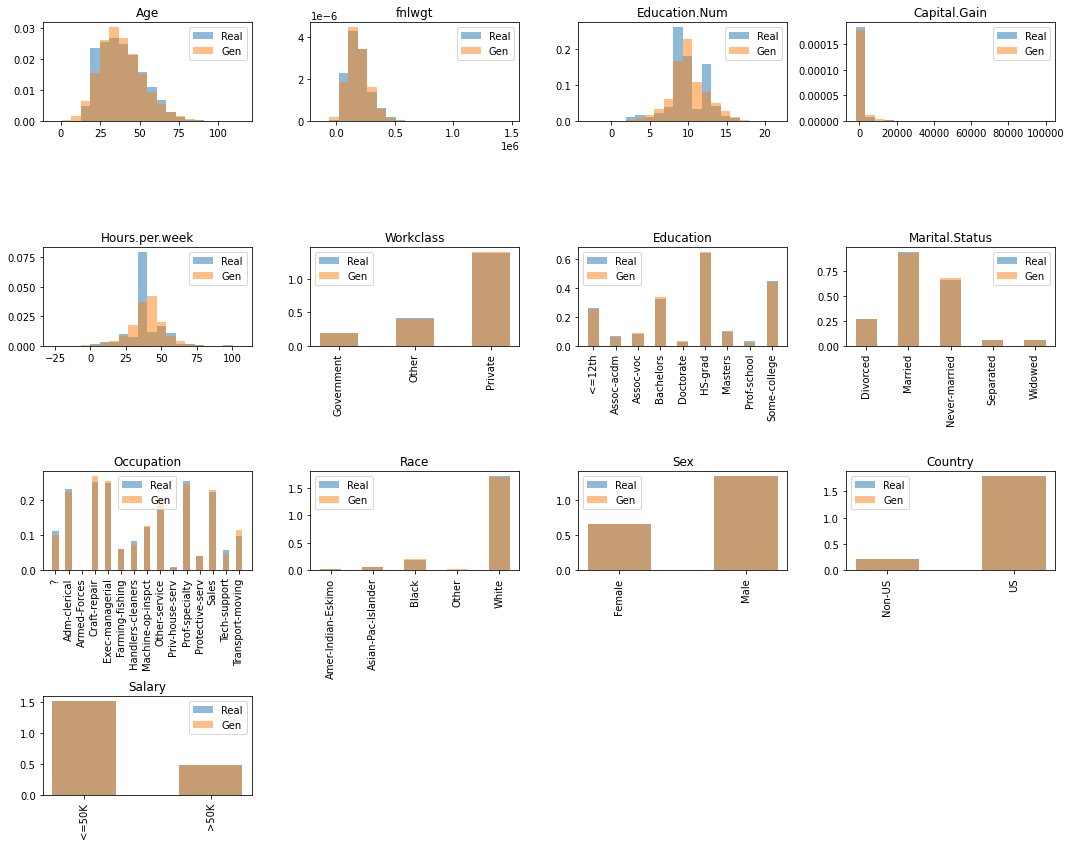

In [146]:
compare_hist_real_vs_generated(tg, discrete_xtick_rotation = 90, 
                               save_path = compare_hist_prefix + "ref" + image_type,
                              save_dir = image_dir)

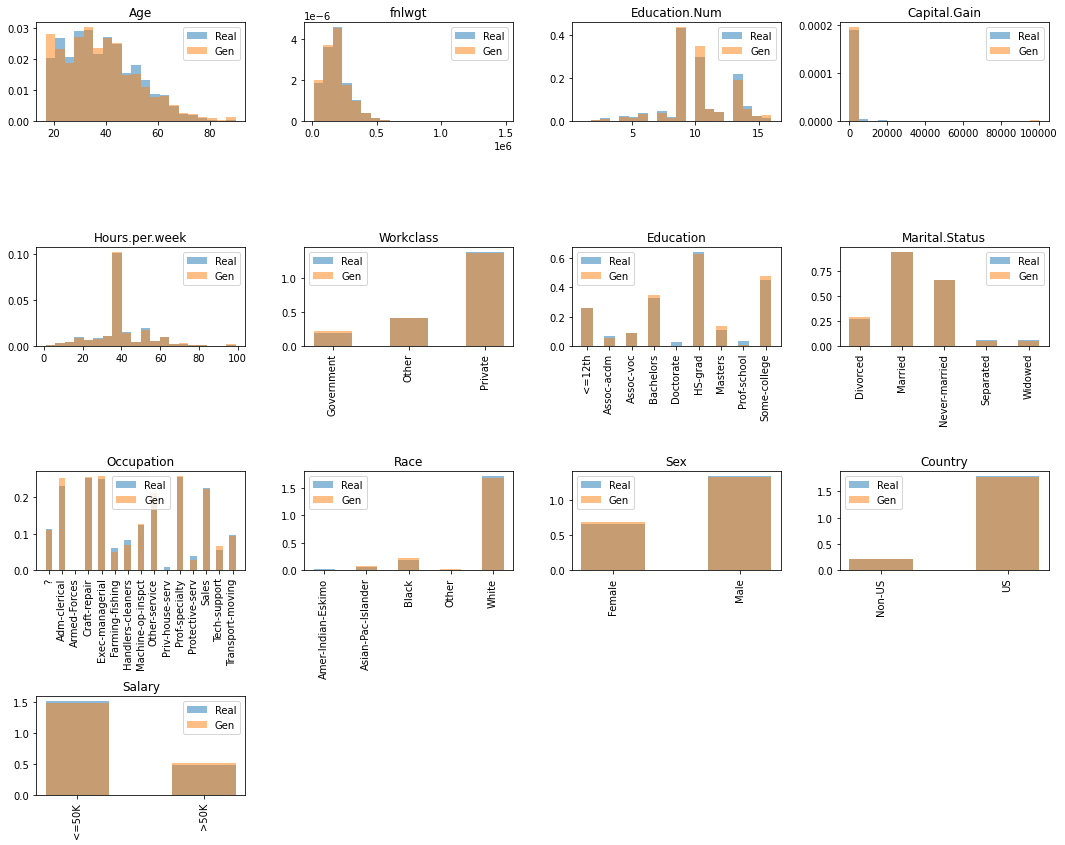

In [147]:
compare_hist_real_vs_generated(tg_qt, discrete_xtick_rotation = 90, 
                               save_path = compare_hist_prefix + "qt" + image_type,
                              save_dir = image_dir)

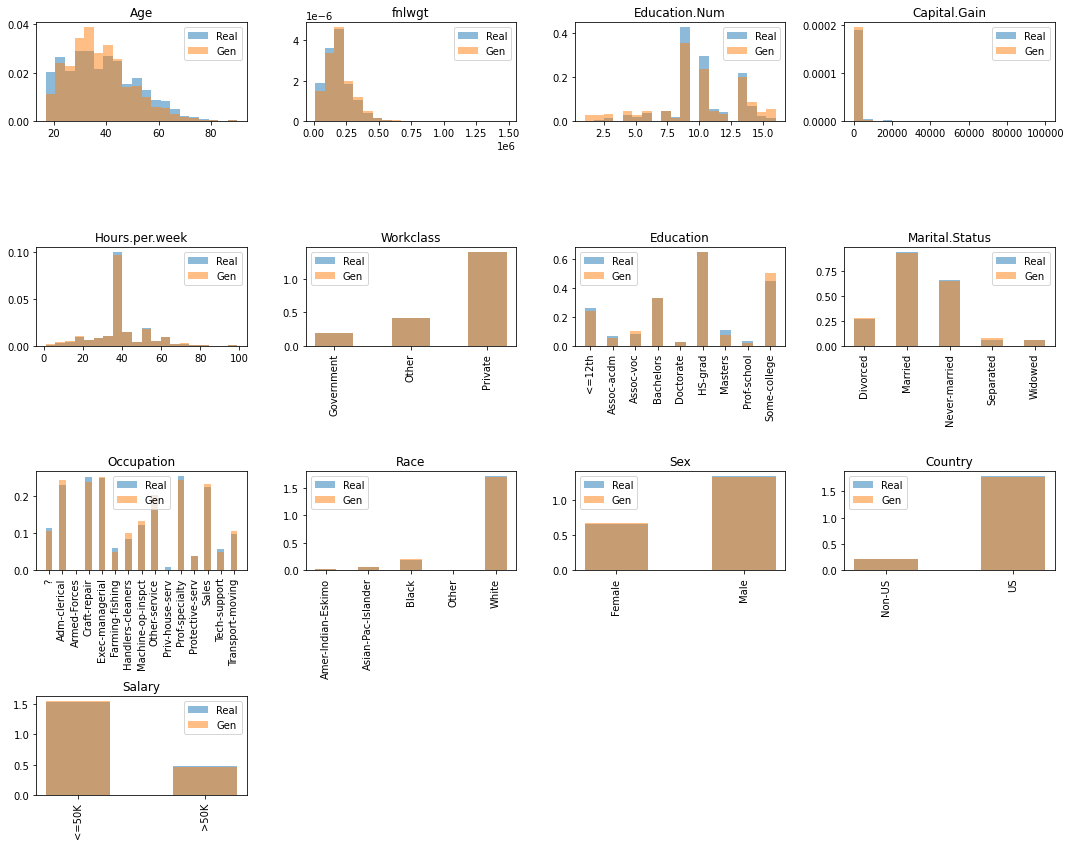

In [148]:
compare_hist_real_vs_generated(tg_qtr, discrete_xtick_rotation = 90, 
                               save_path = compare_hist_prefix + "qtr" + image_type,
                              save_dir = image_dir)

In [9]:
from ctgan import CTGANSynthesizer
if retrain:
    ctgan = CTGANSynthesizer(epochs=20, discriminator_steps = 5)
    ctgan.fit(data, tg.columns_discrete)
    ctgan.save(model_dir + "ctgan.pkl")

In [10]:
ctgan = CTGANSynthesizer.load(model_dir + "ctgan.pkl")

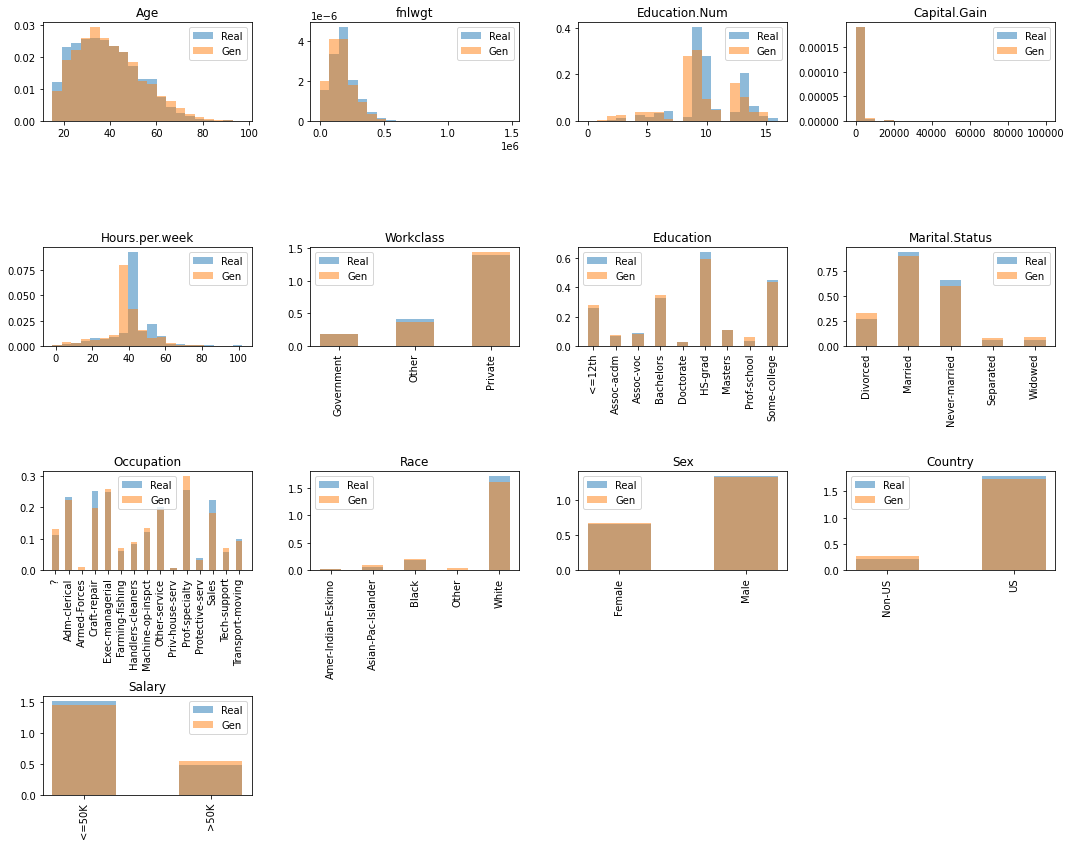

In [14]:
ctgan_synthetic_data = ctgan.sample(tg.nrow)
compare_hist_real_vs_generated(tg_qt, other_gen_dataset = ctgan_synthetic_data, discrete_xtick_rotation = 90, 
                               save_path = compare_hist_prefix + "qtr" + image_type,
                              save_dir = image_dir)

In [33]:
from tgan.model import TGANModel
tgan = TGANModel(tg.columns_num, max_epoch = 5, num_dis_hidden = 256)
tgan.fit(data)

RuntimeError: tf.placeholder() is not compatible with eager execution.

In [18]:
from table_evaluator import load_data, TableEvaluator
table_evaluator = TableEvaluator(data, ctgan_synthetic_data)
# table_evaluator.visual_evaluation()

['True dataset', 'tabGAN', 'tabGAN-qt', 'tabGAN-qtr']


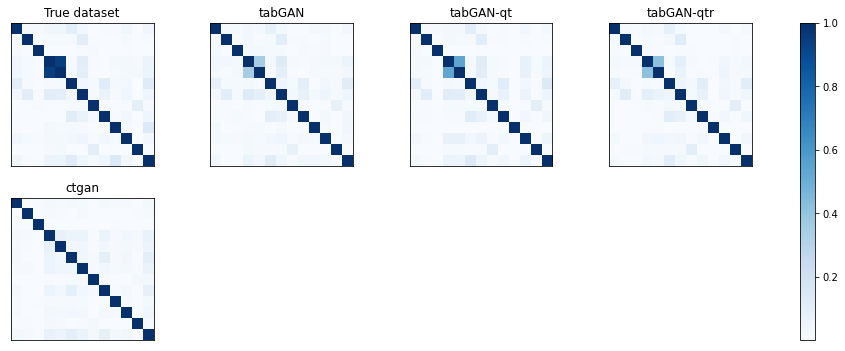

In [164]:
%run "$utils_path"
compare_nmi_matrices([tg, tg_qt, tg_qtr],
                     extra_datasets = [ctgan_synthetic_data],
                     ncol = 4, subplot_titles_tgans =  ["tabGAN", "tabGAN-qt", "tabGAN-qtr"],
                     subplot_titles_extra_datasets = ["ctgan"])